In [1]:

import random
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torch.utils.tensorboard import SummaryWriter
import spacy

from seq2seq.transformers import helpers
from seq2seq import utils

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
# sns.set() Problems with attention

In [2]:
# Load language packecks
nlp_en = spacy.load("en")
nlp_es = spacy.load("es")

In [3]:
# Names
EXPERIMENT_NAME = "runs/transformer"
MODEL_NAME = "simple_transformer"

# Build model and initialize
DATASET_NAME = "miguel"  # multi30k, miguel
DATASET_PATH = f"../../.data/{DATASET_NAME}"
ALLOW_DATA_PARALLELISM = False
MAX_SRC_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH_TEST = int(MAX_TRG_LENGTH * 1.0)  # len>1.0 is not supported by all models
CHECKPOINT_PATH = f'../checkpoints/simple_transformer_2.pt'
SOS_WORD = '<sos>'
EOS_WORD = '<eos>'

## Load vocabularies

In [4]:
# Set fields
SRC = data.Field(tokenize='spacy', tokenizer_language="en", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
TRG = data.Field(tokenize='spacy', tokenizer_language="es", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
fields = [('src', SRC), ('trg', TRG)]

# Load vocabulary
src_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/src_vocab.pkl')
trg_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/trg_vocab.pkl')
print("Vocabularies loaded!")

# Add vocabularies to fields
SRC.vocab = src_vocab
TRG.vocab = trg_vocab
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (es) vocabulary: {len(TRG.vocab)}")

/home/salvacarrion/anaconda3/envs/mltests/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Vocabularies loaded!
Unique tokens in source (en) vocabulary: 10000
Unique tokens in target (es) vocabulary: 10000


## Set up model


In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(utils.gpu_info())

- Using GPU: True
- No. devices: 1
- Device name (0): GeForce GTX 1070


In [6]:
from seq2seq.models import s2s_6_transfomer as builder
model = builder.make_model(src_field=SRC, trg_field=TRG,
                           max_src_len=MAX_SRC_LENGTH, max_trg_len=MAX_TRG_LENGTH, device=device,
                           data_parallelism=ALLOW_DATA_PARALLELISM)


# Load best model
model.load_state_dict(torch.load(CHECKPOINT_PATH))
print("Model loaded!")

# Set for evaluation
model.eval()

The model has 11,695,888 trainable parameters
Data parallelism: False
Model loaded!


Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(10000, 256)
    (pos_embedding): Embedding(102, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

## A few translations

In [7]:
src_sentence = "Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States of America from 2009 to 2017."

# Beam 1
(src_tokens, trans_tokens), _ = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=1)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)

# Beam 3
(src_tokens, trans_tokens), _ = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=3)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)


- Original: 'Hussein obama ii is an american Politician and who served as the President of the united states of america from 2009 to.'
	=> Translation #1: 'Obama es un político norteamericano y que como presidente de los estados unidos de américa a partir de 2009 a.'
- Original: 'Hussein obama ii is an american Politician and who served as the President of the united states of america from 2009 to.'
	=> Translation #1: 'El señor obama ii es un político norteamericano y que como presidente de los estados unidos de américa a partir de 2009 a.'
	=> Translation #2: 'La segunda obama es un político norteamericano y que como presidente de los estados unidos de américa a partir de 2009 a.'
	=> Translation #3: 'Obama es un político norteamericano y que como presidente de los estados unidos de américa a partir de 2009 a.'


('Hussein obama ii is an american Politician and who served as the President of the united states of america from 2009 to.',
 [[...], [...], [...]])

In [8]:
src_sentence = "The United Nations is an intergovernmental organization that aims to maintain international peace and security, develop friendly relations among nations, achieve international cooperation, and be a centre for harmonizing the actions of nations."

# Beam 1
(src_tokens, trans_tokens), _ = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=1)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)

# Beam 3
(src_tokens, trans_tokens), _ = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=3)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)


- Original: 'The united nations is an intergovernmental Organization that aims to maintain international Peace and Security, develop friendly Relations among Nations, achieve international Cooperation, and be a Centre for the Actions of Nations.'
	=> Translation #1: 'Las naciones unidas son una organización intergubernamental que tiene como objetivo mantener la paz y la seguridad internacionales, desarrollar relaciones entre las naciones, lograr la cooperación internacional y ser un centro para las acciones de las naciones.'
- Original: 'The united nations is an intergovernmental Organization that aims to maintain international Peace and Security, develop friendly Relations among Nations, achieve international Cooperation, and be a Centre for the Actions of Nations.'
	=> Translation #1: 'Naciones unidas es una organización intergubernamental que tiene por objeto mantener la paz y la seguridad internacionales, desarrollar relaciones entre las naciones, lograr la cooperación internaciona

('The united nations is an intergovernmental Organization that aims to maintain international Peace and Security, develop friendly Relations among Nations, achieve international Cooperation, and be a Centre for the Actions of Nations.',
 [[...], [...], [...]])

In [9]:
src_sentence = "The agreement of the European Economic Area in August 1992."

# Beam 1
(src_tokens, trans_tokens), _ = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=1)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)

# Beam 3
(src_tokens, trans_tokens), attns = model.translate(src_sentence, max_length=MAX_TRG_LENGTH_TEST, beam_width=3)
utils.show_translation_pair(src_tokens, trans_tokens, nlp_src=nlp_en, nlp_trg=nlp_es)



- Original: 'The Agreement of the european economic Area in august 1992.'
	=> Translation #1: 'El acuerdo del espacio económico europeo en agosto de 1992.'
- Original: 'The Agreement of the european economic Area in august 1992.'
	=> Translation #1: 'En agosto de 1992, el acuerdo del espacio económico europeo.'
	=> Translation #2: 'El acuerdo del espacio económico europeo en agosto de 1992.'
	=> Translation #3: 'La aprobación del espacio económico europeo en agosto de 1992.'


('The Agreement of the european economic Area in august 1992.',
 [[...], [...], [...]])

## Visualize attention


## Attention from different beams

/home/salvacarrion/Documents/Programming/Python/mltests/seq2seq/utils.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, rotation=45)
/home/salvacarrion/Documents/Programming/Python/mltests/seq2seq/utils.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


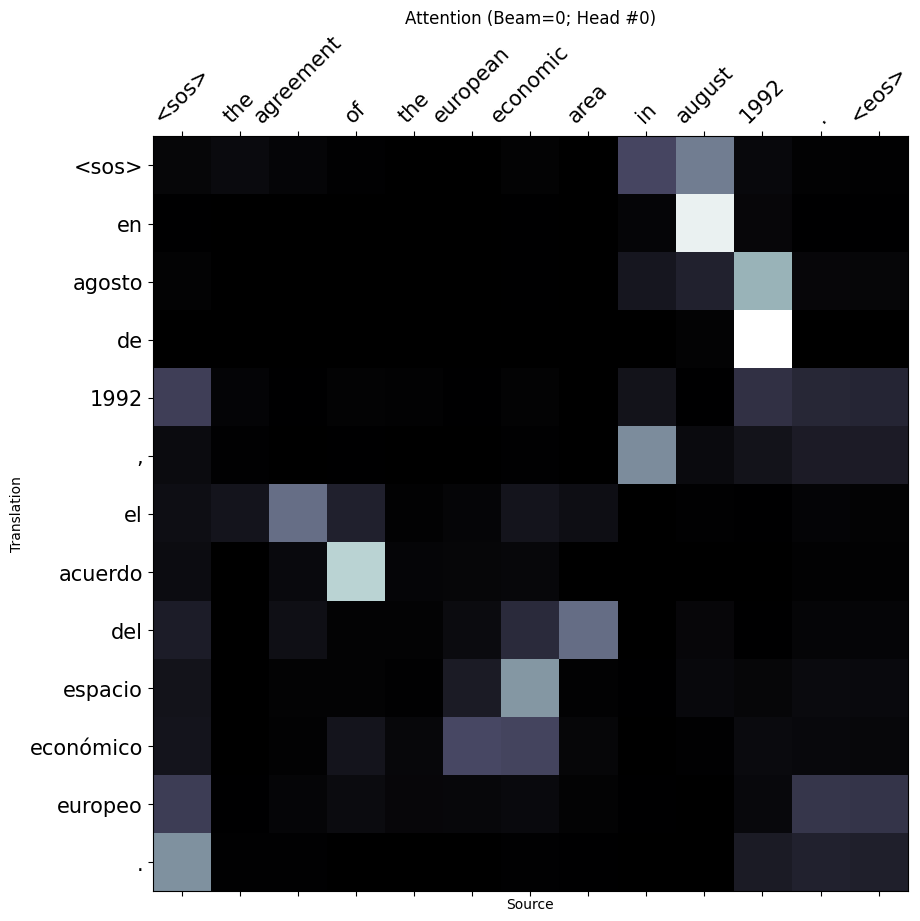

In [10]:
# Plot attention
beam_i = 0
head_i = 0
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")


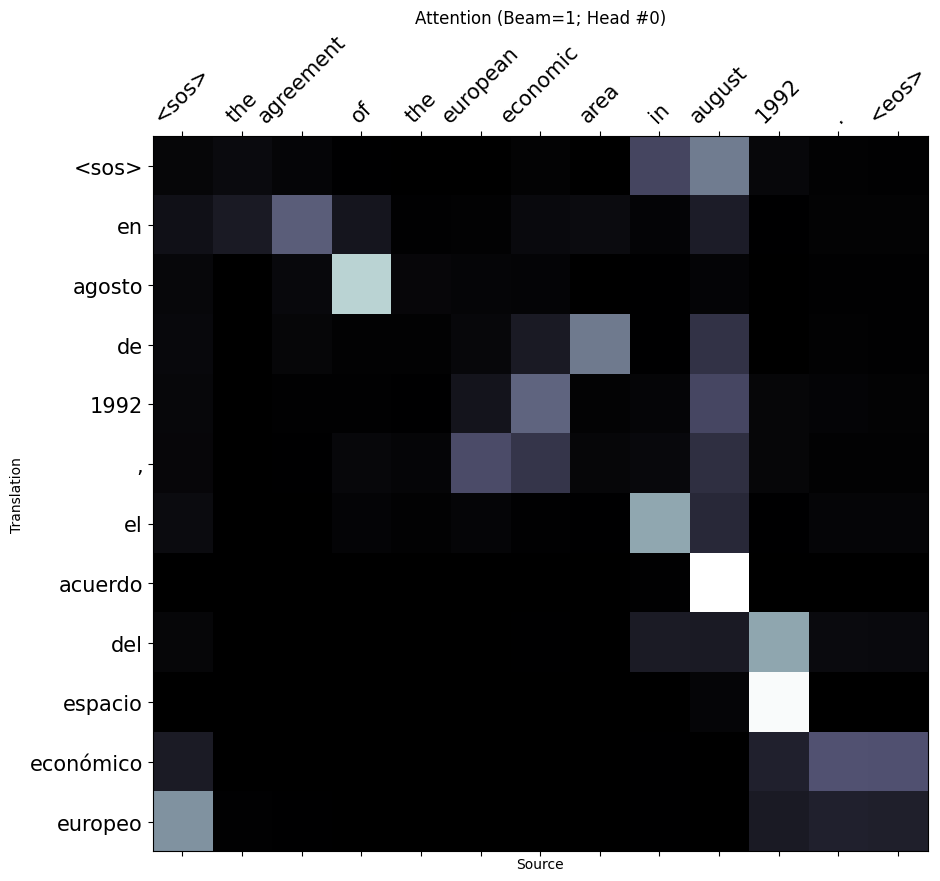

In [11]:
# Plot attention
beam_i = 1
head_i = 0
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

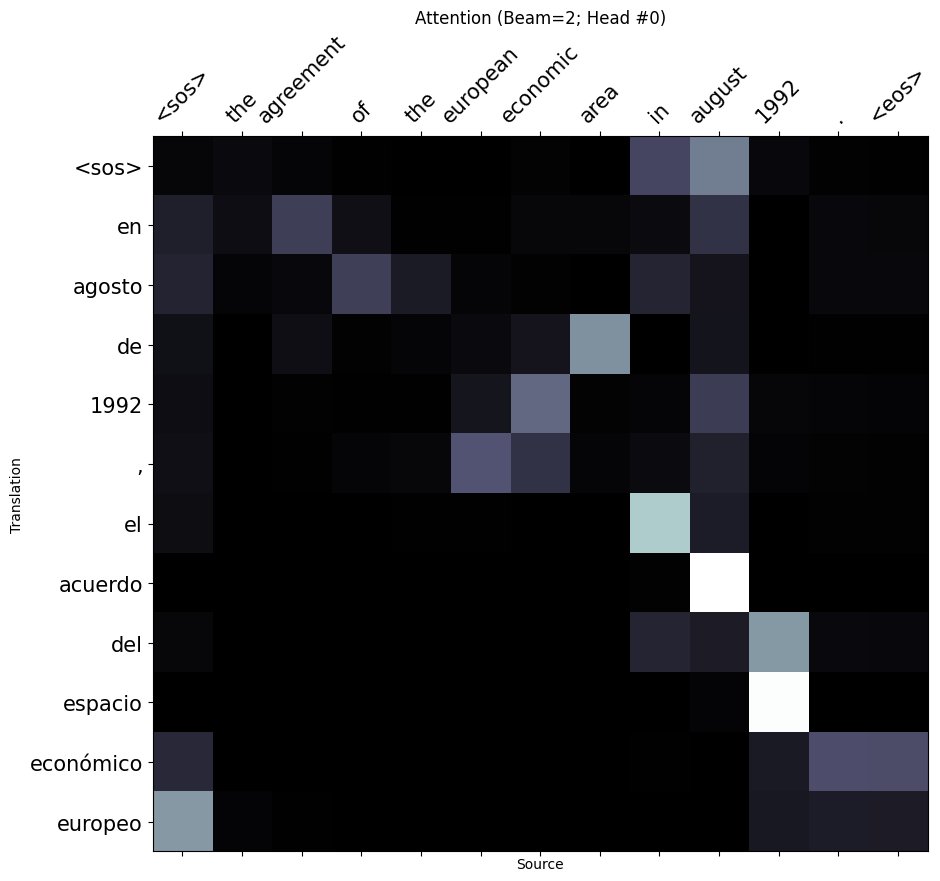

In [12]:
# Plot attention
beam_i = 2
head_i = 0
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

## Attention from different heads

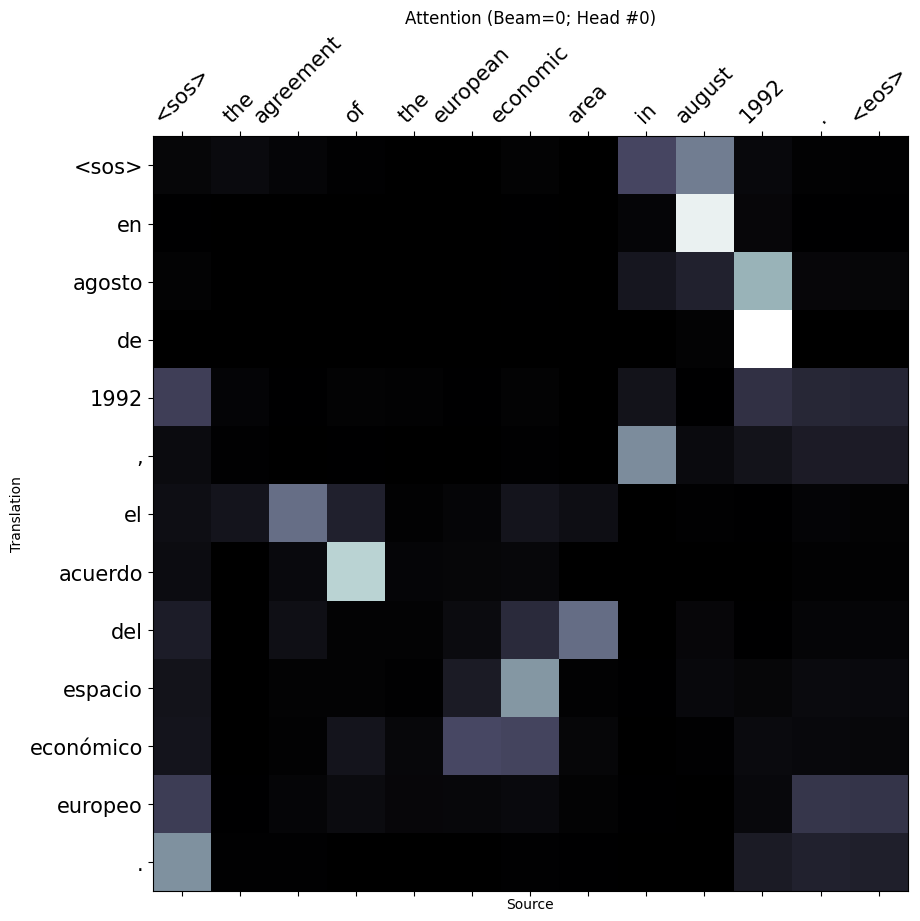

In [13]:
# Plot attention
beam_i = 0
head_i = 0
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

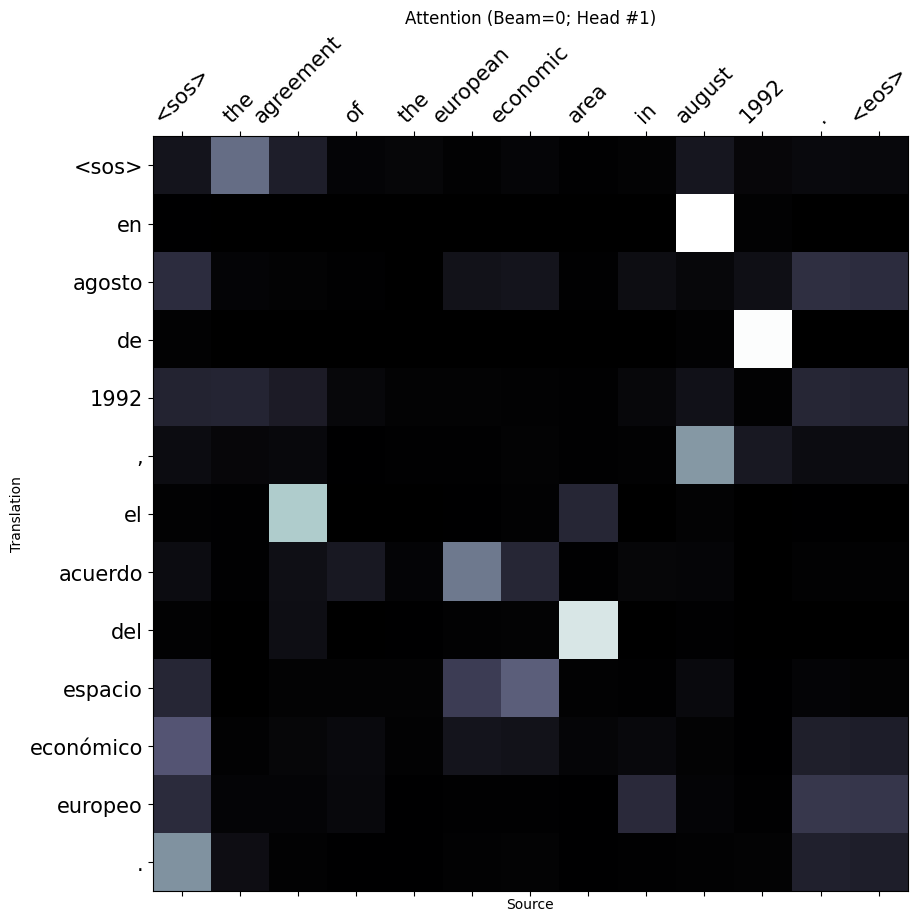

In [14]:
# Plot attention
beam_i = 0
head_i = 1
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")


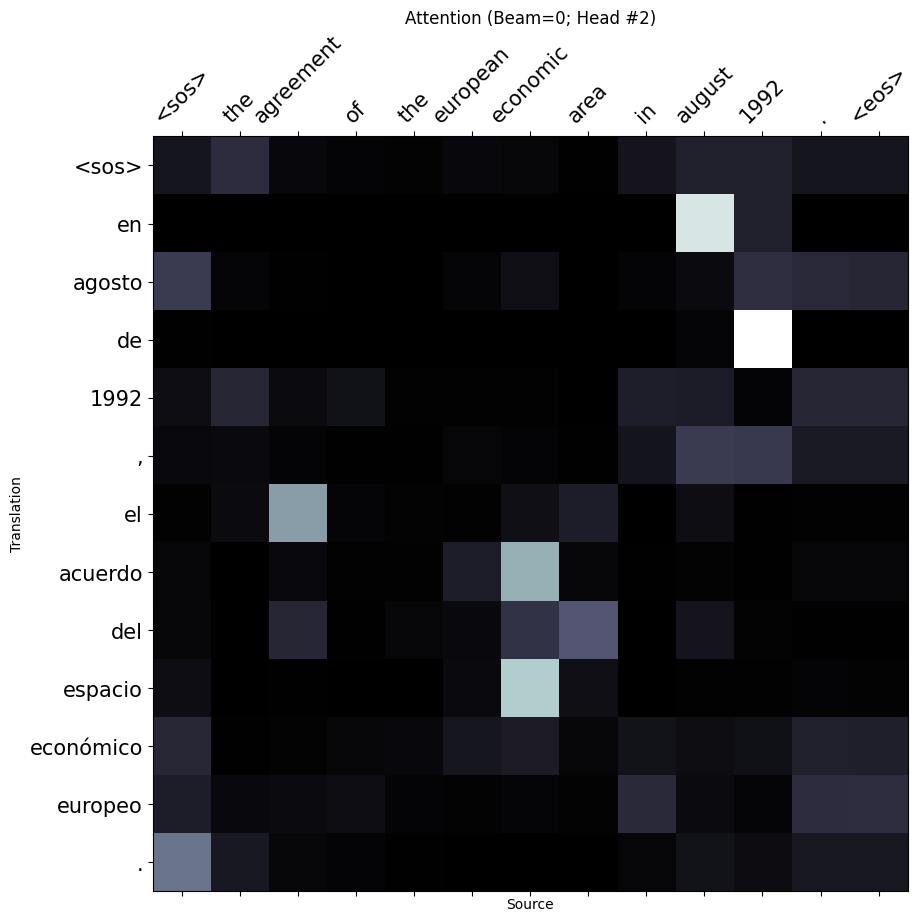

In [15]:
# Plot attention
beam_i = 0
head_i = 2
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")


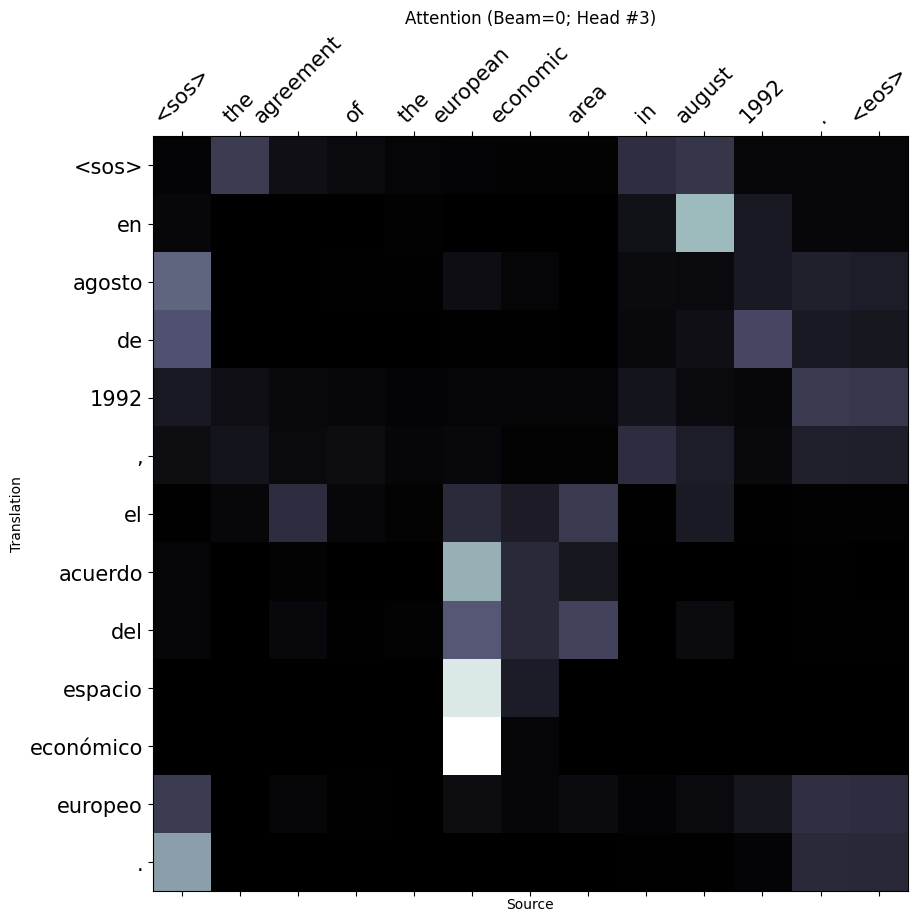

In [16]:
# Plot attention
beam_i = 0
head_i = 3
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")


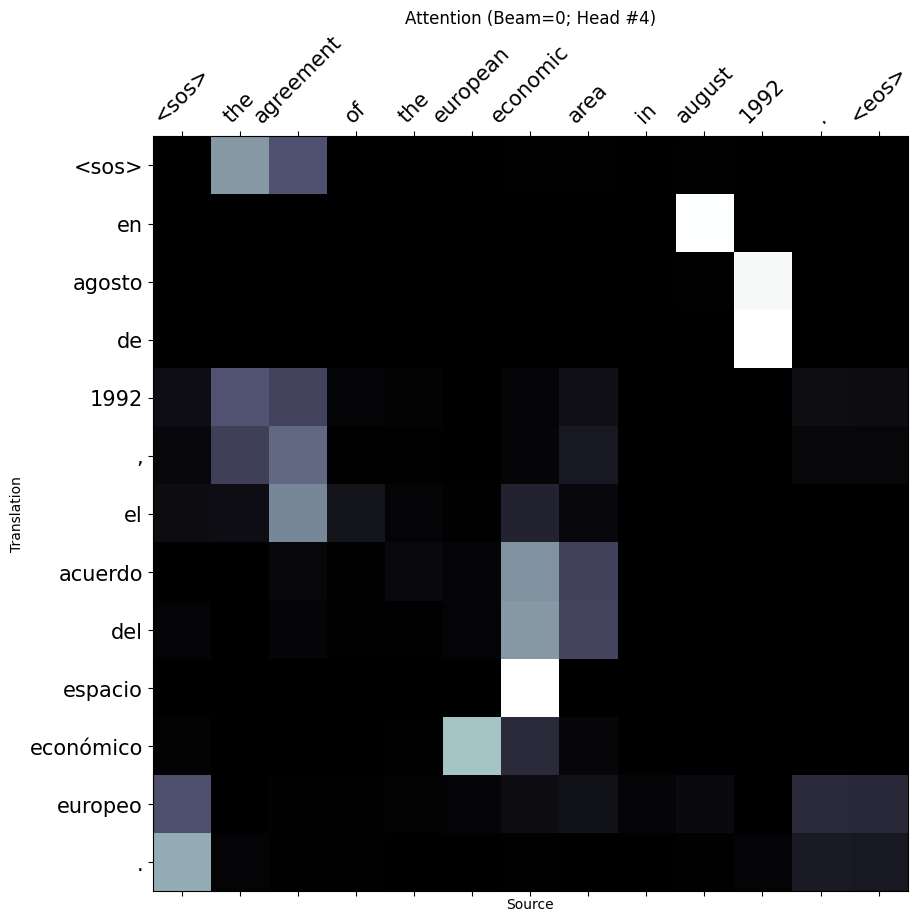

In [17]:
# Plot attention
beam_i = 0
head_i = 4
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

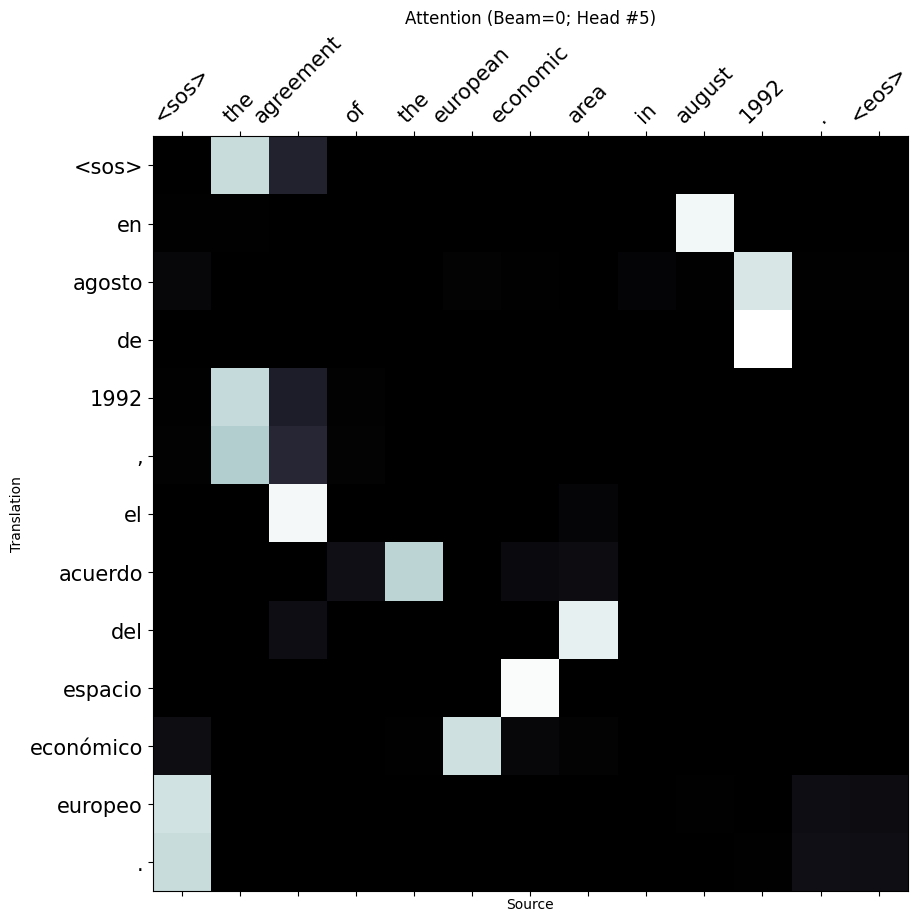

In [18]:
# Plot attention
beam_i = 0
head_i = 5
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

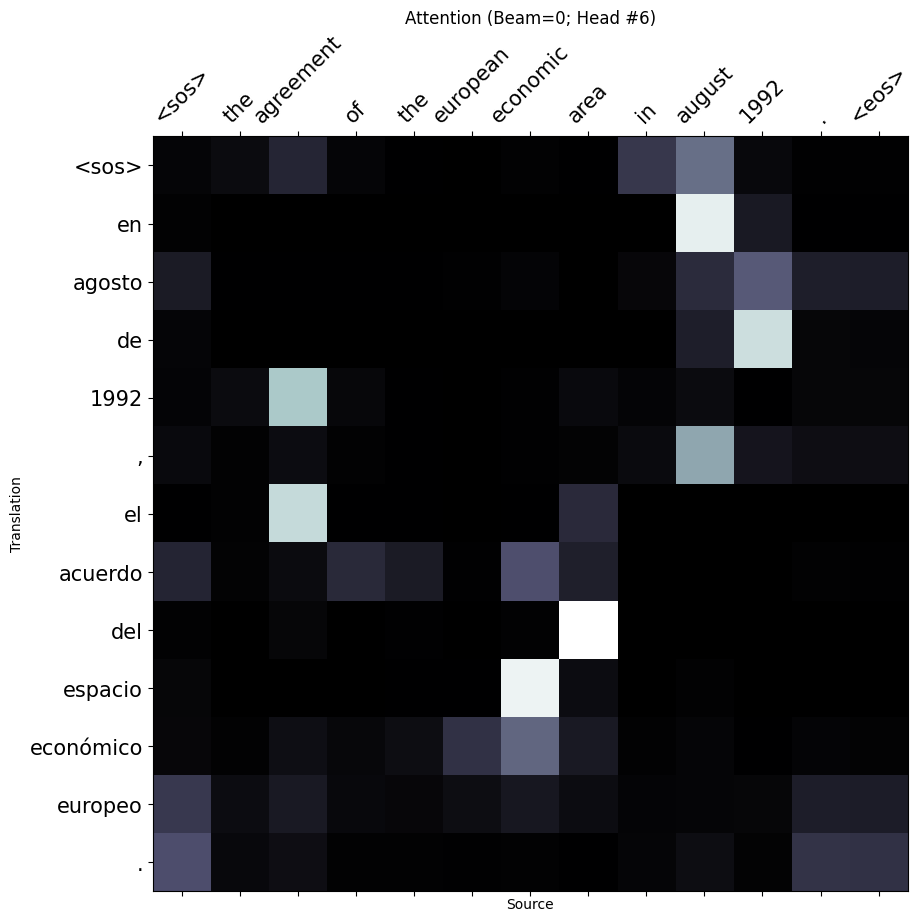

In [19]:
# Plot attention
beam_i = 0
head_i = 6
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")

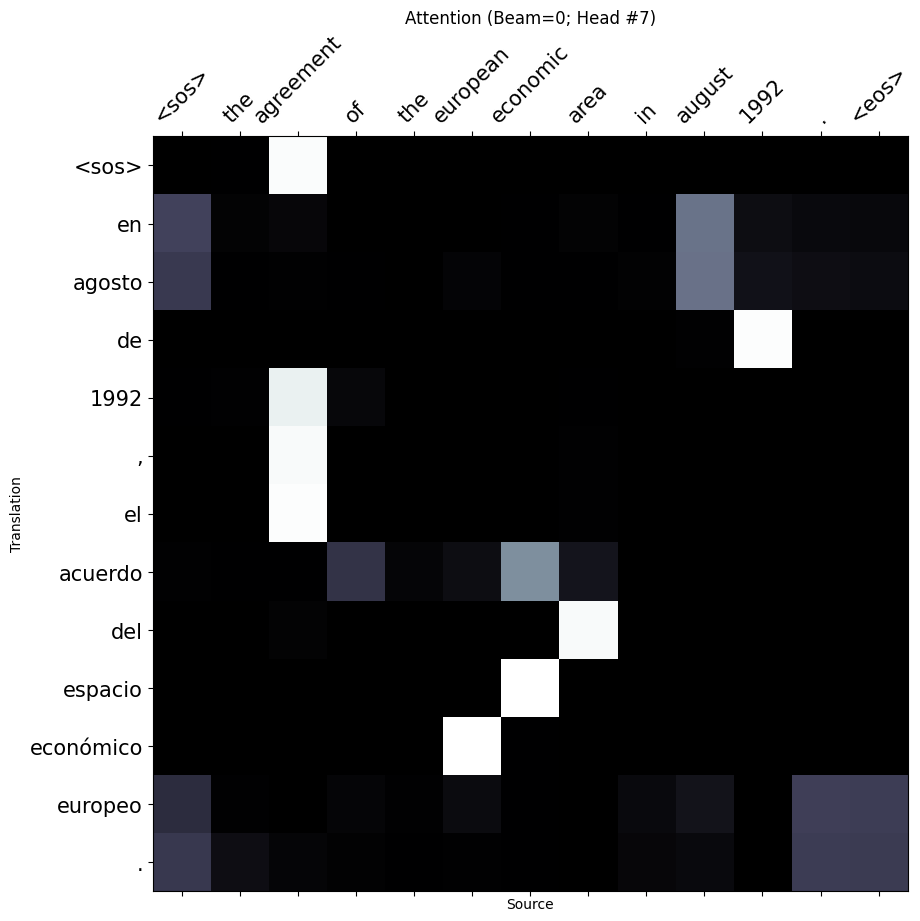

In [20]:
# Plot attention
beam_i = 0
head_i = 7
attn = attns[beam_i][0]  # Remove Beam and Batch
utils.display_attention(src_tokens, trans_tokens[0], attn[head_i], title=f"Attention (Beam={beam_i}; Head #{head_i})")